In [1]:
%matplotlib inline

In [2]:
import networkx as nx
import numpy as np

from matplotlib.patches import Polygon

import pandas as pd

import matplotlib.pyplot as plt

In [3]:
from colonists import (get_nodes, get_hex_paths, get_hexes, assign_region_hex_indexes,
                       shuffle_regions, DEFAULT_MAP, plot_hexes, get_hex_roll_order,
                       assign_collect_index, get_hex_links)

--------------------------------------------------

# Initial hex layout

 - Arrange land hexes in random order.
 - Arrange port hexes in random order, interleaved with sea hexes
   (one sea hex between each pair of port hexes).


In [4]:
df_nodes = get_nodes(8, 17, .165, 1.75)
df_hex_paths = get_hex_paths(df_nodes)

hex_count = df_hex_paths.hex.unique().max() + 1
df_hexes = get_hexes(hex_count, DEFAULT_MAP, port_offset=1)
assign_region_hex_indexes(df_hexes, inplace=True)

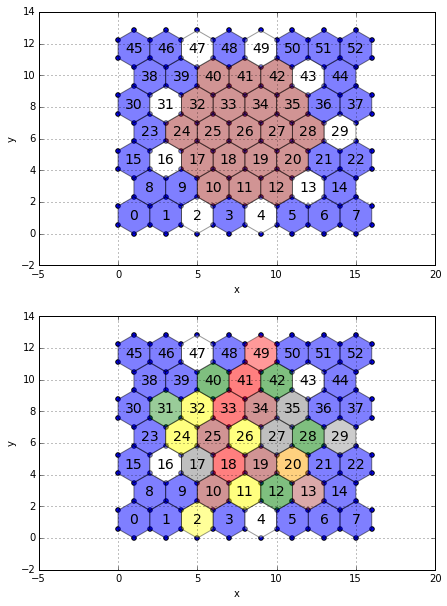

In [5]:
shuffle_regions(df_hexes, inplace=True)
fig, axes = plt.subplots(2, figsize=(8, 10))
plot_hexes(df_nodes, df_hexes, colorby='region', axis=axes[0])
plot_hexes(df_nodes, df_hexes, colorby='terrain', axis=axes[1])

--------------------------------------------------

# Active port hex vertices

## TODO ##

 - Find the pair of nodes associated with each port.
     * Some port hexes may have more than two vertices (i.e., nodes)
       contacting adjacent land hexes.  In such cases, according to
       the rules, only two nodes must be selected, which are on the
       side of the hex port facing the most (i.e., 4 instead of 3)
       land hexes.
       
### Strategy for determining port nodes

 1. For each port, find list of nodes adjacent (through *hex link*) to
    one or more land hexes.
 2. Order nodes from (1) according to `[hex, vertex_i]` from hex path.
 3. For each port hex, for each pair of nodes (e.g., `(0, 1), (1, 2)`):
     1. Compute equation for tangent to line connecting the pair of nodes.
     2. Compute the distance of the center of each *land* hex to tangent
        line.
     3. Count number of *land* hexes with center within $\epsilon$ distance
        of the tangent line (i.e., number of land hex tiles intersected by
        tangent line).
     4. Select pair of nodes for each port hex with highest number of *land*
        tiles intersected by tangent line.

--------------------------------------------------

# Dice roll number assignments

 - Assign a dice roll number to each land hex

1 3


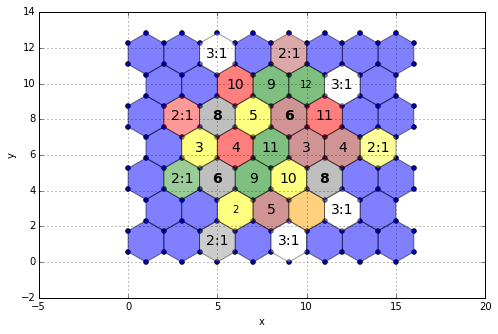

In [8]:
# np.random.seed(0)

clockwise = np.random.randint(2)
shift = np.random.randint(0, 6)
print clockwise, shift

shuffle_regions(df_hexes, inplace=True)
if 'collect_index' in df_hexes:
    df_hexes.drop('collect_index', axis=1, inplace=True)
hex_roll_order = get_hex_roll_order(shift=shift, clockwise=clockwise)
assign_region_hex_indexes(df_hexes, inplace=True)
assign_collect_index(df_hexes, hex_roll_order, inplace=True)

fig, axis = plt.subplots(figsize=(8, 10))
plot_hexes(df_nodes, df_hexes, colorby='terrain', axis=axis,
           labelby='collect_index')